In [4]:
from google.colab import files
files.upload()  # Upload kaggle.json



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shrutik10","key":"60cd659016b3af35b3a83a9313afb67f"}'}

In [2]:
import tensorflow as tf

In [3]:
print("TensorFlow version:", tf.__version__)
print("Is GPU being used by TensorFlow?", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.18.0
Is GPU being used by TensorFlow? True


In [5]:
# ✅ STEP 2: Set up Kaggle API
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [15]:
# ✅ STEP 3: Download the dataset from Kaggle
# Replace with the correct Kaggle dataset identifier
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset


Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors


In [16]:
# ✅ STEP 4: Unzip the dataset
!unzip -q plant-disease-recognition-dataset.zip -d plant_disease_data
!ls plant_disease_data


replace plant_disease_data/Test/Test/Healthy/8ddaa5a5caa5caa8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace plant_disease_data/Test/Test/Healthy/8ddaac1bd6c8cd0a.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace plant_disease_data/Test/Test/Healthy/8ddd5ec1c0de38c4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Test  Train  Validation


In [17]:
# importing
import os

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras as k
from keras.models import Sequential
from keras.layers import Conv2D,BatchNormalization,Activation,GlobalAveragePooling2D,Dropout,Dense,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

In [22]:
# Storing Dataframe addresses
train=r'plant_disease_data/Train/Train'
test=r'plant_disease_data/Test/Test'
val=r'plant_disease_data/Validation/Validation'

In [23]:
import os

train_data_dir = 'plant_disease_data/Train/Train'
print("Train directory contents:", os.listdir(train_data_dir))


Train directory contents: ['Rust', 'Healthy', 'Powdery']


In [24]:
import os

train = r'plant_disease_data/Train/Train'  # Update this path if needed
print("Train directory contents:", os.listdir(train))

# Check inside class folders
for class_name in ["Healthy", "Powdery", "Rust"]:
    class_path = os.path.join(train_data_dir, class_name)
    print(f"{class_name} contains:", os.listdir(class_path)[:5])

Train directory contents: ['Rust', 'Healthy', 'Powdery']
Healthy contains: ['81cb3d2572b29b99.jpg', '88e178d578d931d5.jpg', '89becd60a683a29f.jpg', '83cbdf3a6cd03606.jpg', '9f9c55656a4592b2.jpg']
Powdery contains: ['ce2b568eb0c197b4.jpg', 'c0171fe57139a92b.jpg', 'c4e97291cf71a2ac.jpg', 'dfe1279ac92430c7.jpg', 'def76a9002058be7.jpg']
Rust contains: ['a8b11628f78a8adf.jpg', 'f3b19b71a064687c.jpg', 'abc397970c5a3c68.jpg', 'f6e501f5b0975423.jpg', 'd0dd3c34c2954d7a.jpg']


****
# Data Augmentation
****

In [25]:
img_size=(224,224)
batch_size=32

# Scaling of Pixel Values for Training data
# Little Augmentation of the Training data for better results :)
trdata=ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

# Scaling of pixel values for Testing and Validation sets
tegen=ImageDataGenerator(rescale=1.0/255)
valgen=ImageDataGenerator(rescale=1.0/255)

In [26]:
traing=trdata.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)
testg = tegen.flow_from_directory(
    test,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)
valg = valgen.flow_from_directory(
    val,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)

Found 1322 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


****
# Displaying Images and Distribution of Classes
****

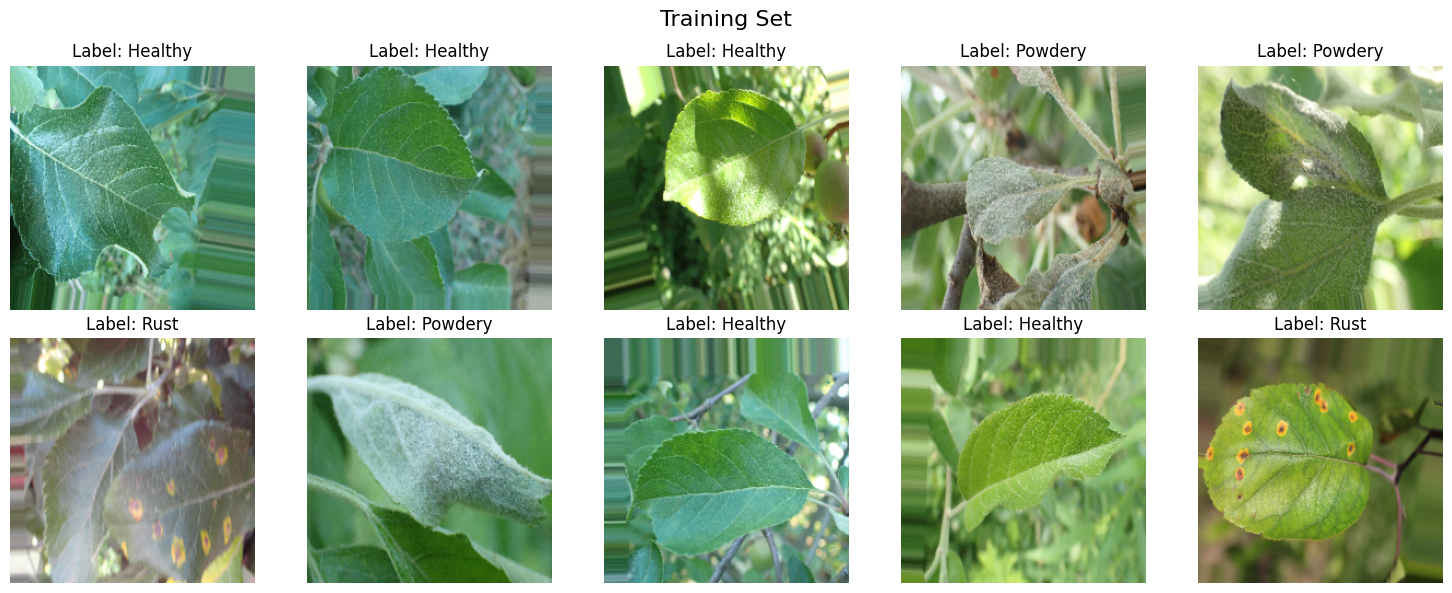

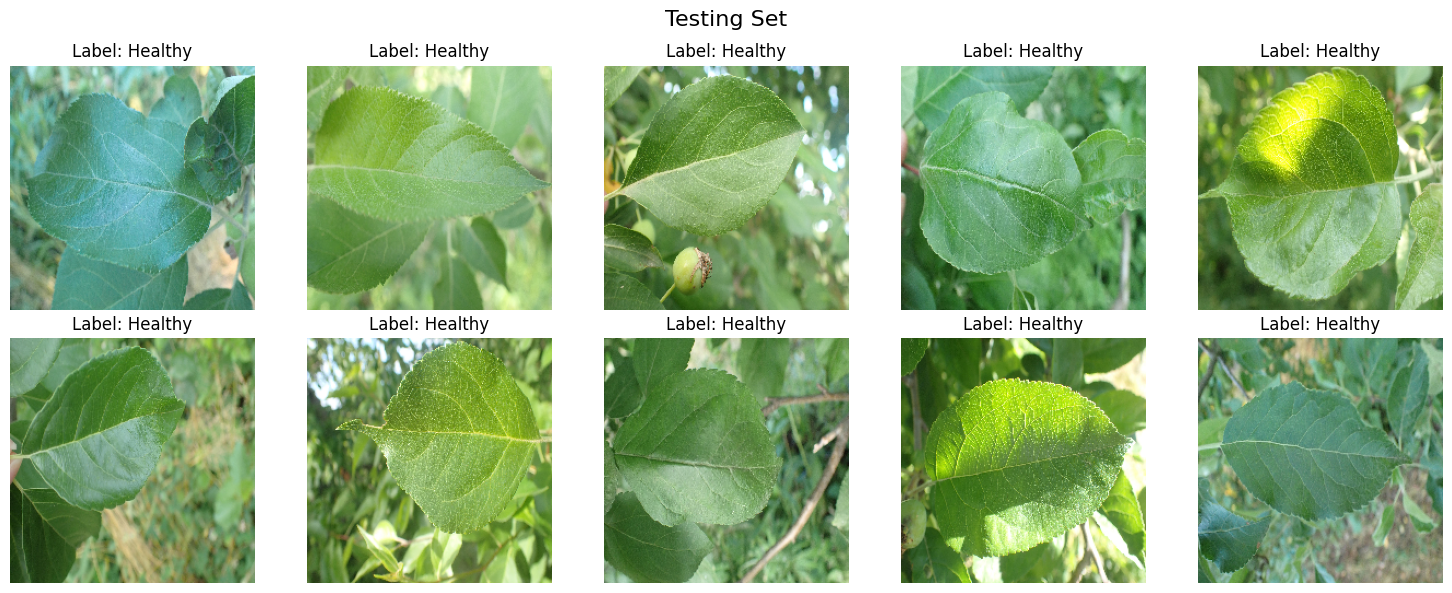

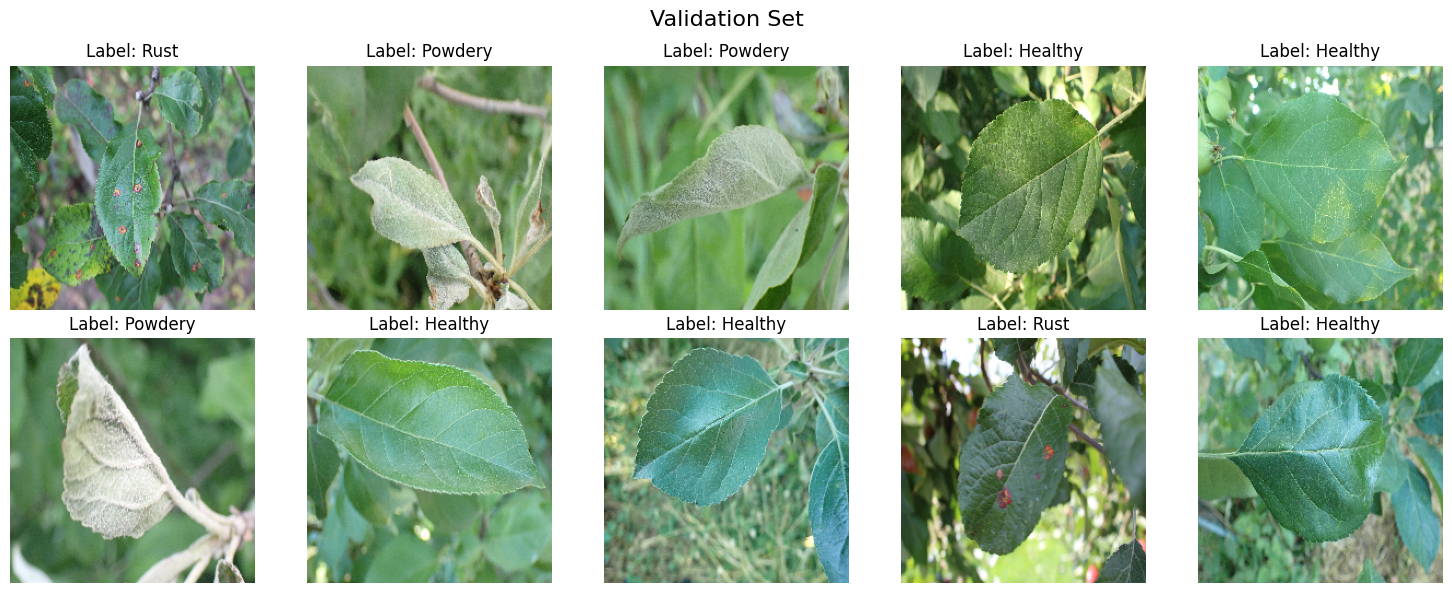

In [27]:
# Displaying the training and testing datsets
# Only 10 Images from each set

def plot_images_from_generator(generator, title, num_images=10, images_per_row=5):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for i in range(num_images):
        img = images[i]
        label = labels[i]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {list(generator.class_indices.keys())[label.argmax()]}")

    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_from_generator(traing, "Training Set", num_images=10, images_per_row=5)
plot_images_from_generator(testg, "Testing Set", num_images=10, images_per_row=5)
plot_images_from_generator(valg, "Validation Set", num_images=10, images_per_row=5)

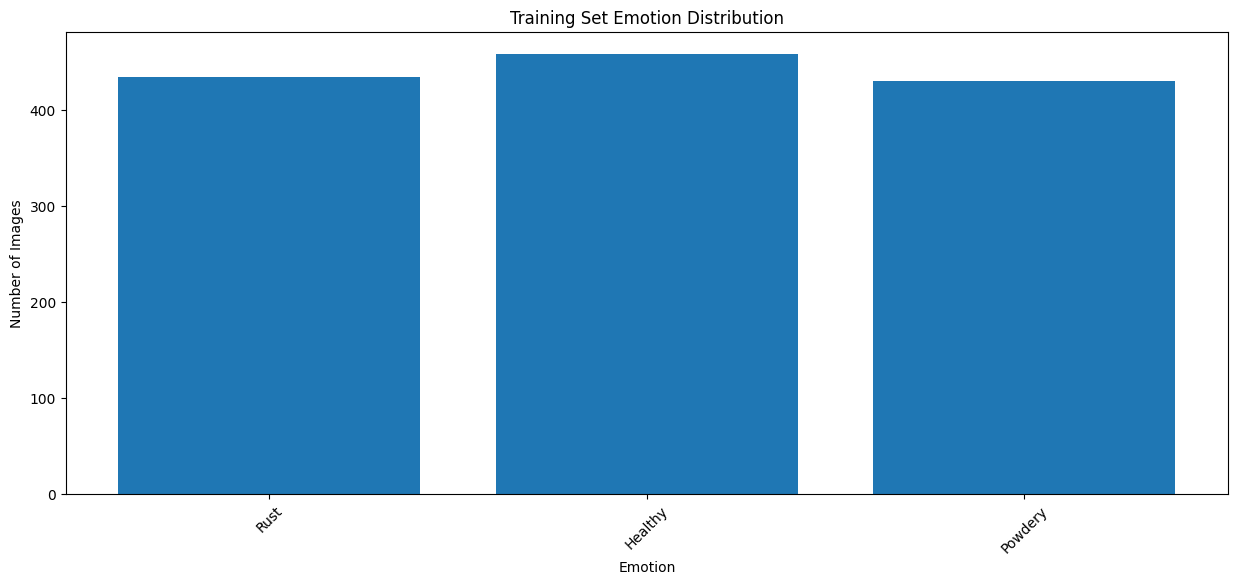

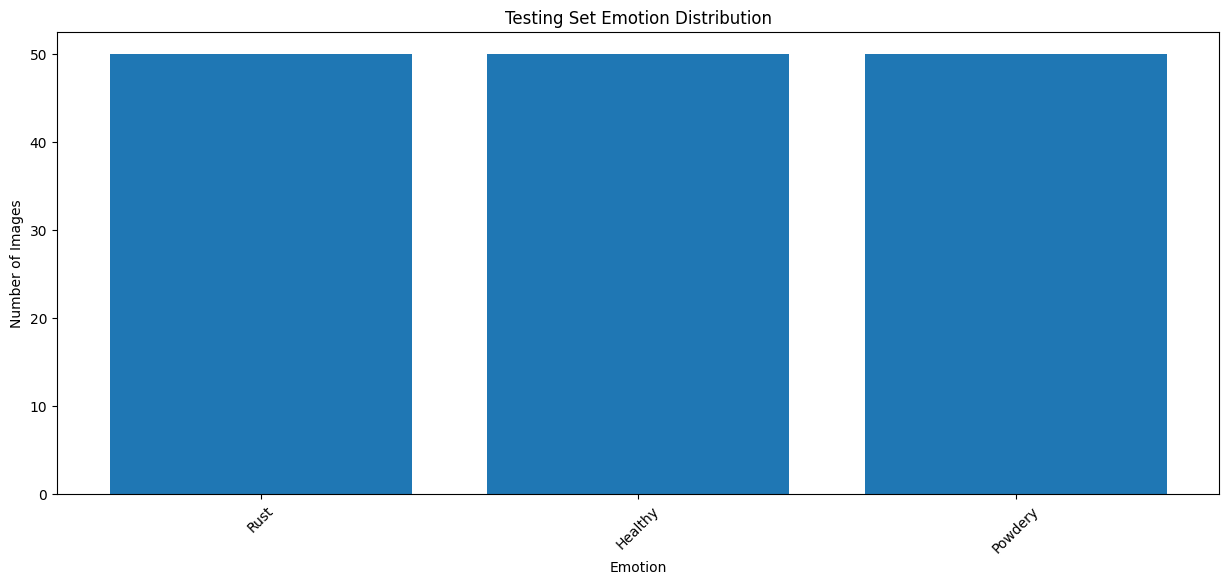

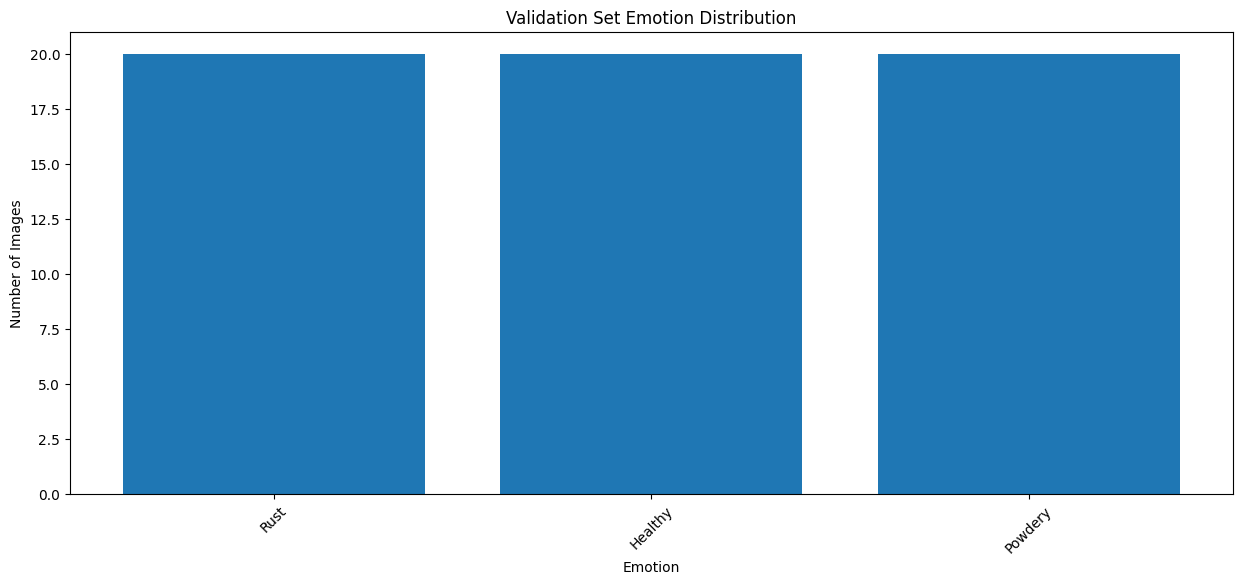

In [28]:
#class distribution

def plot_class_distribution(directory, title):
    class_names = os.listdir(directory)
    class_counts = []
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts.append(len(os.listdir(class_dir)))

    plt.figure(figsize=(15, 6))
    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train, "Training Set Emotion Distribution")
plot_class_distribution(test, "Testing Set Emotion Distribution")
plot_class_distribution(val, "Validation Set Emotion Distribution")

****
# CNN Model
****

In [29]:
model = Sequential()

# CNN Layer 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#CNN Layer 2
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#CNN Layer 3
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Global Average Pooling layer is used instead of Flatten as it is more effiecient
#Note: There is feature loss when we use GAP
model.add(GlobalAveragePooling2D())

#Dense Layer 1
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer 2
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer 3
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Output Layer
model.add(Dense(3, activation='softmax'))

#Adam Optimizer
opt = k.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,115,203 (4.25 MB)

 Trainable params: 1,110,851 (4.24 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [30]:
# Some callbacks to help us
# I will be using EarlyStopping and Reduce Learining Rate
es=EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, verbose=1, min_delta=0.0001)

callbacks_list=[es,lr]

In [31]:
# Fit the model :)
history = model.fit(
    traing,
    epochs=70,
    validation_data=valg,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.5245 - loss: 1.3323 - val_accuracy: 0.3333 - val_loss: 1.1922 - learning_rate: 0.0010
Epoch 2/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6087 - loss: 1.1320 - val_accuracy: 0.3333 - val_loss: 1.7236 - learning_rate: 0.0010
Epoch 3/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7189 - loss: 0.8215 - val_accuracy: 0.3333 - val_loss: 2.3625 - learning_rate: 0.0010
Epoch 4/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7267 - loss: 0.7692 - val_accuracy: 0.3333 - val_loss: 2.0981 - learning_rate: 0.0010
Epoch 5/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7864 - loss: 0.6126 - val_accuracy: 0.3333 - val_loss: 2.8236 - learning_rate: 0.0010
Epoch 6/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7907 - loss: 0.5729 - val_accuracy: 0.3333 - val_loss: 3.5204 - learning_rate: 0.0010
Epoch 7/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8262 - loss: 0.4841 - val_accuracy:

****
# Prediction
****

In [32]:
# Predicting
y_pred = np.argmax(model.predict(testg), axis=1)
y_true = testg.classes


5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


****
# Evaluation Metrics
****

Accuracy:  0.9066666666666666
Recall:  0.9066666666666666
Precision:  0.9178294573643412
F1 Score:  0.9078399559277511
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        50
           1       1.00      0.94      0.97        50
           2       0.95      0.82      0.88        50

    accuracy                           0.91       150
   macro avg       0.92      0.91      0.91       150
weighted avg       0.92      0.91      0.91       150



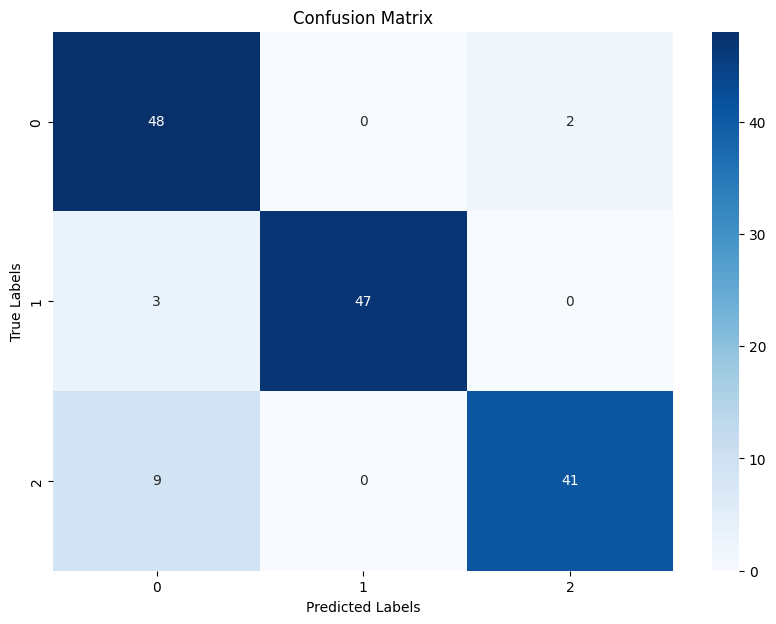

Training class indices: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}
Test class indices: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}


In [33]:
print('Accuracy: ',accuracy_score(y_true, y_pred))
print('Recall: ',recall_score(y_true, y_pred,average='weighted'))
print('Precision: ',precision_score(y_true, y_pred,average='weighted'))
print('F1 Score: ',f1_score(y_true, y_pred,average='weighted'))

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            )
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print Training and Test Class Indices
print("Training class indices:", traing.class_indices)
print("Test class indices:", testg.class_indices)


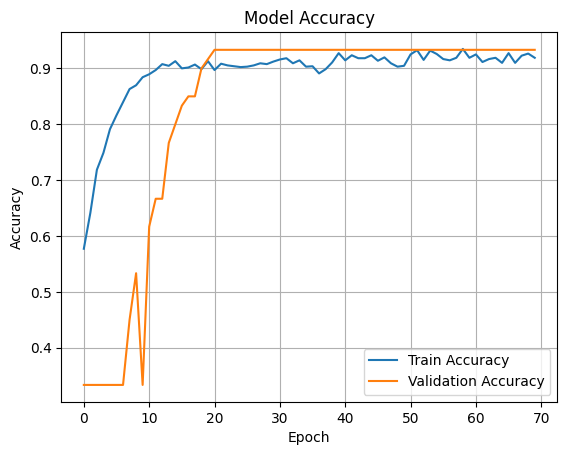

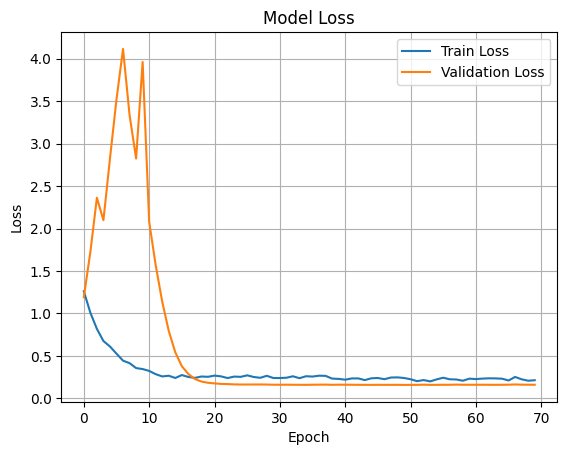

In [35]:
# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


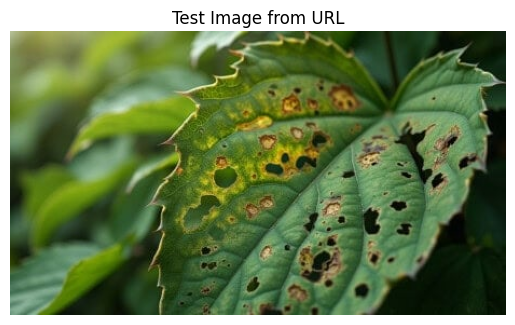

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🔍 Predicted Class: Rust


In [38]:
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# URL of the test image
img_url = "https://www.planetnatural.com/wp-content/uploads/2012/12/anthracnose-1-460x263.jpg"

# === Download and display the image ===
response = requests.get(img_url)
img = Image.open(BytesIO(response.content)).convert("RGB")

plt.imshow(img)
plt.axis('off')
plt.title("Test Image from URL")
plt.show()

# === Resize and preprocess ===
img = img.resize(img_size)  # Example: (224, 224)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# === Prediction ===
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction)

# Get class names from training generator
class_names = list(traing.class_indices.keys())
predicted_class = class_names[predicted_index]

print(f"🔍 Predicted Class: {predicted_class}")
